In [0]:
!pip install tensorflow==2.0

In [16]:
!pip install Pillow

## Occlusion Experiments for object segmentation

This notebook tries to replicate the method and results of occlusion experiments conducted by M. Zeiler et al in their paper <em>"Visualising and understanding convolutional neural networks".</em> 

In this paper, the authors zero out parts of the input image, feed it into a trained ConvNet for detection and monitor the output of the classifier. This leads to the generation of a **heat-map whose values are a function of the classifier output when those parts were occluded in the original input image**. 


In [0]:
from copy import deepcopy
import json
import matplotlib.pyplot as plt 
import matplotlib.image as mpimage
import numpy as np
from skimage.transform import resize
from scipy.misc import imsave

# DNN specific imports
import tensorflow as tf
import tensorflow.keras.backend as K 
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image

In [0]:
def decode_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        results.append(result)
    return results

In [0]:
# to reformat images as (batchsize, 299, 299, 3)
def reformat(input):
    x = np.zeros((len(input), 299, 299, 3))
    for i in xrange(len(input)):
        x[i, :,:,0] = input[i][:,:,0]
        x[i, :,:,1] = input[i][:,:,1]
        x[i, :,:,2] = input[i][:,:,2]
    return x

### Occlusion Generator class
This class lazily generates occluded images at run time. This is done because preloading a set of occluded images would just eat up my ram.  

In [0]:
class OcclusionGenerator(object):
     
    def __init__(self, img, boxsize=10, step=10, prepocess=True):
        ''' Initializations '''
        self.img = img
        self.boxsize = boxsize
        self.step = step 
        self.i = 0
        self.j = 0
    

    def flow(self):
        ''' Return a single occluded image and its location '''
        if self.i + self.boxsize > self.img.shape[0]:
            return None, None, None
        
        retImg = np.copy(self.img)
        retImg[self.i:self.i+self.boxsize, self.j:self.j+self.boxsize] = 0.0 

        old_i = deepcopy(self.i) 
        old_j = deepcopy(self.j)
        
        # update indices
        self.j = self.j + self.step
        if self.j+self.boxsize>self.img.shape[1]: #reached end
            self.j = 0 # reset j
            self.i = self.i + self.step # go to next row
        return retImg, old_i, old_j

    def gen_minibatch(self, batchsize=10):
        ''' Returns a minibatch of images of size <=batchsize '''
        # list of occluded images
        occ_imlist = []
        locations = []
        for i in xrange(batchsize):
            occimg, i, j = self.flow()
            if occimg is not None:
                occ_imlist.append(occimg)
                locations.append([i,j])

        if len(occ_imlist)==0: # no data
            return None,None
        else:
            # convert list to numpy array and pre-process input (0 mean centering)
            x = reformat(occ_imlist)
            return x, locations 


In [0]:
!wget -O dog.jpeg https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/most-loyal-dog-breeds-st-bernard-1571189105.jpg

In [0]:
!wget -O car.jpg https://stimg.cardekho.com/images/carexteriorimages/630x420/Maruti/Swift/6318/1572069250647/front-left-side-47.jpg

In [0]:
!wget https://raw.githubusercontent.com/akshaychawla/Occlusion-experiments-for-image-segmentation/master/imagenet_class_index.json

In [0]:
# testing out the occlusion generator class
img = mpimage.imread("dog.jpeg")
img = resize(img, (299,299,3))

occ = OcclusionGenerator(img, 40, 10, False)
occList = []
plt.rcParams['figure.figsize'] = (10, 10)
for i in xrange(50):
    img, x, y = occ.flow()
    occList.append(img)
    # print(x, y)

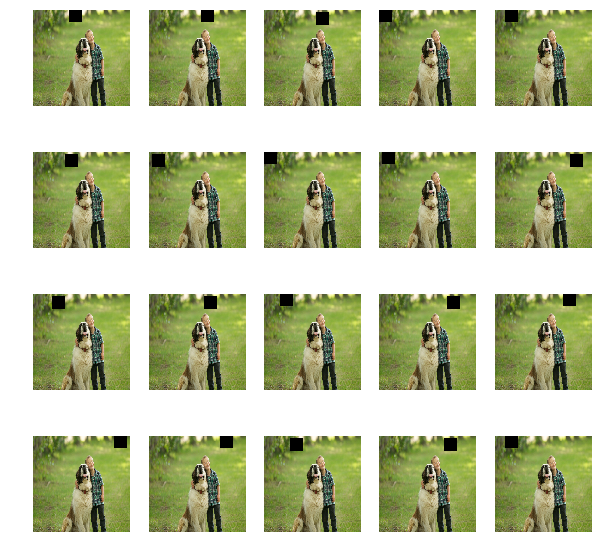

In [221]:
for i in range(1, 21):
    plt.subplot(4,5,i)
    plt.imshow(occList[np.random.randint(len(occList))])
    plt.axis("off")

In [0]:
# this function takes a list of heatmaps and merges them into one single heatmap
def post_process(heatmap):
    # postprocessing
    total = heatmap[0]
    for val in heatmap[1:]:
        total = total + val
    return total

In [0]:
#### This is the meat of the program. It generates the heatmap for the given image location ####

def gen_heatmap(fileloc, boxsize, step, verbose=True, savetodisk=False):

    # load up image 
    img = mpimage.imread(fileloc)
    img = resize(img, (299,299,3))
    if verbose:
        plt.imshow(img)
        plt.axis("off")
        plt.show()

    # classify image (w/o occlusions)
    model = InceptionV3(weights='imagenet')
    x = np.expand_dims(img, axis=0)
    preds = model.predict(x)
    correct_class_index = np.argmax(preds[0])

    # load correct label text 
    f = open("imagenet_class_index.json", "rt")
    imagenet_labels = json.load(f)
    f.close()
    correct_class_label = imagenet_labels[str(correct_class_index)][1]
    if verbose:
        print(correct_class_label)

    # generate occluded images and location of mask
    occ = OcclusionGenerator(img, boxsize, step, True)

    # scores of occluded image
    heatmap = []
    index = 0
    while True:

        # get minibatch of data
        x, locations = occ.gen_minibatch(batchsize=10)

        if x is not None:

            #predict 
            op = model.predict(x)

            #unpack prediction values 
            for i in xrange(x.shape[0]):
                score = op[i][correct_class_index]
                r,c = locations[i] 
                scoremap = np.zeros((299,299))
                scoremap[r : r+occ.boxsize, c : c+occ.boxsize] = score
                heatmap.append(scoremap)

            if verbose:
                print('..minibatch completed')
        else:
            break

    if savetodisk:
        #save heatmap to disk 
        import cPickle as pickle
        f = open("heatmap", 'wb')
        pickle.dump(heatmap, f)
        f.close()

    return heatmap, correct_class_index, correct_class_label

In [224]:
heatmapList, index, label = gen_heatmap("dog.jpeg", 20, 10, False)
processed = post_process(heatmapList)

(1, 299, 299, 3)


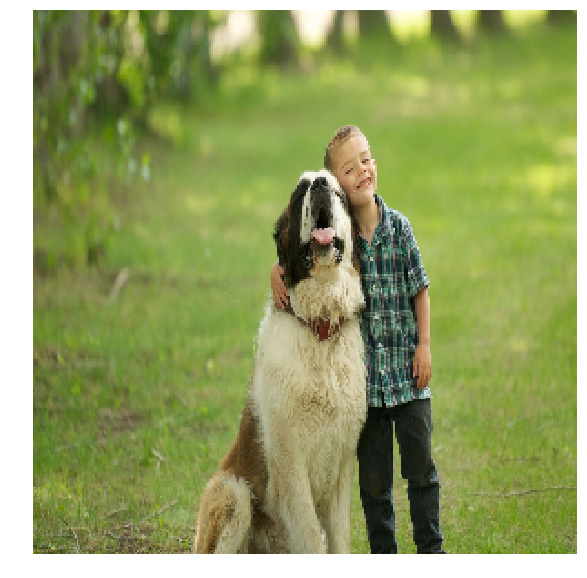

In [225]:
# load up image 
img = mpimage.imread('dog.jpeg')
img = resize(img, (299,299,3))
plt.imshow(img)
plt.axis("off")
plt.show()

In [0]:
# classify image (w/o occlusions)
model = InceptionV3(weights='imagenet')
x = reformat([img])

In [0]:
preds = model.predict(x)
correct_class_index = np.argmax(preds[0])

In [229]:
correct_class_index

247

In [230]:
preds[0][correct_class_index]

0.9417762

In [0]:
f = open("imagenet_class_index.json", "rt")
imagenet_labels = json.load(f)
f.close()
correct_class_label = imagenet_labels[str(correct_class_index)][1]

In [232]:
imagenet_labels[str(correct_class_index)]

[u'n02109525', u'Saint_Bernard']

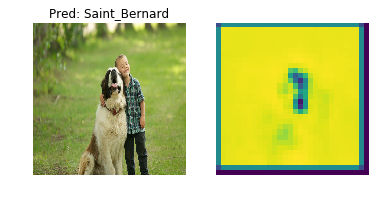

In [234]:
%matplotlib inline
img = mpimage.imread('dog.jpeg')
img = resize(img, (299,299,3))
plt.subplot(121)
plt.imshow(img)
plt.axis("off")
plt.title("Pred: "+label)
plt.subplot(122)
plt.imshow(processed)
plt.axis("off")
plt.show()

## Testing on Car Image

In [235]:
heatmapList, index, label = gen_heatmap("car.jpg", 20, 10, False)
processed = post_process(heatmapList)

(1, 299, 299, 3)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


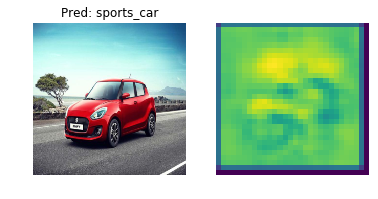

In [237]:
img = mpimage.imread('car.jpg')
img = imresize(img, (299,299,3))
plt.subplot(121)
plt.imshow(img)
plt.axis("off")
plt.title("Pred: "+label)
plt.subplot(122)
plt.imshow(processed)
plt.axis("off")
plt.show()